<a href="https://colab.research.google.com/github/e-chong/Singapore-Ship-Detection/blob/master/kaggle_deep_learning_with_sentinel_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# install libraries

# suppress output
%%capture 

!pip install rasterio
!pip install geopandas
!pip install sentinelsat
!pip install satpy
!pip install glymur
!pip install python-geotiepoints
!pip install pyspectral
!pip install progressbar2
!pip install kaggle
!pip install tifffile

In [2]:
%tensorflow_version 1.x
%matplotlib inline

TensorFlow 1.x selected.


In [0]:
# Base dependencies
import numpy as np
import pandas as pd
import geopandas as gpd # vector spatial operations
import rasterio as rio # raster spatial operations
import json

# Plotting
from rasterio.plot import show #convenience wrapper for pyplot.imshow for RGB and 1 band images
import matplotlib.pyplot as plt

#Sentinel-2 I/O
from sentinelsat import SentinelAPI
from satpy.scene import Scene
from satpy import find_files_and_readers
import requests, zipfile, io, os, shutil # downloading and extracting zipfolders

# Sentinel-2 create patches
from shapely.geometry import Point # vector geometries
import time
import progressbar

# Resize Kaggle patches
from skimage.transform import resize
import tifffile as tiff
import scipy.ndimage


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#Functions
credit to # https://gis.stackexchange.com/questions/299787/finding-pixel-location-in-raster-using-coordinates

In [0]:
# Extracts RGB 3-channel image from SAFE directory and saves it in the working directory 
# and returns the path to the new file
def extract_rgb_jp2(safePath, sceneTitle):
  for subdirs, dirs, files in os.walk(safePath):
    for file in files:
      if file.endswith('_TCI.jp2'):
        rgbPath = os.path.join(subdirs, file)
        destPath = sceneTitle+'.jp2'
        print(f'Copying {file} to {destPath}')
        shutil.copy2(rgbPath, destPath)
        return destPath

In [0]:
# returns matrix of [n ships, patch_size, patch_size]
def create_ship_patches(ships, img, patch_size=50):
  coordinates = list(zip(ships.geometry.x, ships.geometry.y))
  with progressbar.ProgressBar(max_value=len(ships.index)) as bar: # creates progress bar
    patch_list = np.zeros([len(ships.index), patch_size, patch_size, len(img.indexes)])
    for i, (lon, lat) in enumerate(coordinates): # Loop through your list of coords
      py, px = img.index(lon, lat) # Get pixel coordinates from map coordinates
      window = rio.windows.Window(px - patch_size//2, py - patch_size//2, patch_size, patch_size) # Build an NxN window
      patch = img.read(window=window) # clip is a nbands * patch_size * patch_size numpy array
      patch_list[i] = np.transpose(patch, (1,2,0)) # transpose to [patch_size, patch_size, n bands]
      bar.update(i)
  return patch_list.astype(int)

In [0]:
# creates patches for use in classifying ship or no ship
def create_patches(img, patch_size=50, step_size=30):
  n_patches = len(range(0,img.height, step_size)) * len(range(0,img.width, step_size))
  patch_list = []
  index = 0
  with progressbar.ProgressBar(max_value=n_patches) as bar: # creates progress bar
    for y in range(0,img.height, step_size): # iterate across image column-wise
      for x in range(0,img.width, step_size): # iterate across image row-wise
        window = rio.windows.Window(x,y, patch_size, patch_size)
        if window.col_off+window.width > img.width or window.row_off+window.height > img.height:
          pass
        else:
          # Read the data in the window
          patch = img.read(window=window) # patch is a nbands * patch_size * patch_size numpy array 
          patch_list.append(np.transpose(patch, (1,2,0))) # transpose to [patch_size, patch_size, n bands]
          index += 1
          bar.update(index)
  patch_array = np.stack(patch_list, axis=0)
  return patch_array.astype(int)

In [0]:
# returns boolean list of whether patches intersect with any ships
def patch_intersects_ship_buffers(ships, img, patch_size=50, step_size=30):
  n_patches = (len(range(0,img.height, step_size)) * len(range(0,img.width, step_size)))
  isShip_list = [] #list to hold all the patch locations
  buffer_list = []
  x_list = []
  y_list = []
  index = 0

  with progressbar.ProgressBar(max_value=n_patches) as bar: # creates progress bar
    for y in range(0,img.height, step_size): # iterate across image column-wise
      for x in range(0,img.width, step_size): # iterate across image row-wise
        window = rio.windows.Window(x,y, patch_size, patch_size) #get patch window
        if window.col_off+window.width > img.width or window.row_off+window.height > img.height:
          pass #skip patches that extend off the edge so they have the wrong shape
        else:
          #create centroid point
          centroid = Point(img.transform *(window.col_off+patch_size/2, window.row_off+patch_size/2))
          buffer = centroid.buffer(img.transform[0]*step_size/1.5)
          buffer_list.append(buffer)
          isShip = np.any(ships.intersects(buffer)) #intersect ships with polygon and check if any are positive
          isShip_list.append(isShip) #append result to list
          x_list.append(x),
          y_list.append(y)
          index += 1
          bar.update(index)
  results = pd.DataFrame({'isShip':isShip_list, 'x':x_list, 'y':y_list, 'patch_size':patch_size})
  return results

In [0]:
# plots a patch
def plot_patch(img, x, y, patch_size=50, step_size=30):
  window = rio.windows.Window(x,y, patch_size, patch_size)
  patch = img.read(window=window)
  show(patch, title=f'x: {x}, y: {y}')

In [0]:
# creates patches for use in classifying ship or no ship
def predict_patch(model, img, x, y, patch_size=50):
  window = rio.windows.Window(x,y, patch_size, patch_size)
  patch = img.read(window=window)
  patch = np.transpose(patch, (1,2,0))
  patch = patch[np.newaxis, :]
  prediction = model.predict_classes(patch)
  return prediction

# Define Parameters

In [0]:
DRIVE_PATH = '/content/drive/My Drive/MUSA-650-Final-Project/'

In [0]:
#Load param file
with open(DRIVE_PATH+'params.json', 'r') as file:
    params = json.load(file)
    
    SENTINEL_USER = params['SENTINEL_USER']
    SENTINEL_PWD = params['SENTINEL_PWD']
    KAGGLE_USER = params['KAGGLE_USER']
    KAGGLE_KEY = params['KAGGLE_KEY']

In [0]:
# unique Sentinel-2 tile id for images covering Singapore
TILE_ID = "48NUG" 

In [0]:
# Patch parameters
PATCH_SIZE = 24
STEP_SIZE = 12
SCALE_FACTOR = 3.7/10 #PlanetScope GSD / Sentinel-2 GSD

# Download Data

## Kaggle PlanetScope

In [16]:
os.mkdir('.kaggle')
os.listdir()

['.config', 'drive', '.kaggle', 'sample_data']

In [0]:
token = {"username":KAGGLE_USER,"key":KAGGLE_KEY}

with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [18]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}

cp: cannot create regular file '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
- path is now set to: {/content}


In [19]:
!kaggle datasets download -d rhammell/ships-in-satellite-imagery -p /content

 95% 177M/185M [00:03<00:00, 66.5MB/s]
100% 185M/185M [00:03<00:00, 58.7MB/s]


In [20]:
os.listdir()

['.config',
 'drive',
 '.kaggle',
 'ships-in-satellite-imagery.zip',
 'sample_data']

In [0]:
with zipfile.ZipFile('ships-in-satellite-imagery.zip', 'r') as kaggleZip:
      kaggleZip.extractall(os.getcwd())

In [22]:
with open('shipsnet.json') as data_file:
    kg_ships_df = pd.DataFrame(json.load(data_file))
print(kg_ships_df.shape)
kg_ships_df.head()

(4000, 4)


,data,labels,locations,scene_ids
0,"[82, 89, 91, 87, 89, 87, 86, 86, 86, 86, 84, 8...",1,"[-118.2254694333423, 33.73803725920789]",20180708_180909_0f47
1,"[76, 75, 67, 62, 68, 72, 73, 73, 68, 69, 69, 6...",1,"[-122.33222866289329, 37.7491755586813]",20170705_180816_103e
2,"[125, 127, 129, 130, 126, 125, 129, 133, 132, ...",1,"[-118.14283073363218, 33.736016066914175]",20180712_211331_0f06
3,"[102, 99, 113, 106, 96, 102, 105, 105, 103, 10...",1,"[-122.34784341495181, 37.76648707436548]",20170609_180756_103a
4,"[78, 76, 74, 78, 79, 79, 79, 82, 86, 85, 83, 8...",1,"[-122.34852408322172, 37.75878462398653]",20170515_180653_1007


In [23]:
with open('shipsnet.json') as data_file:
    kg_ships_dict = json.load(data_file)

kg_ships_df = pd.DataFrame(kg_ships_dict)
kg_ships_df.head()

,data,labels,locations,scene_ids
0,"[82, 89, 91, 87, 89, 87, 86, 86, 86, 86, 84, 8...",1,"[-118.2254694333423, 33.73803725920789]",20180708_180909_0f47
1,"[76, 75, 67, 62, 68, 72, 73, 73, 68, 69, 69, 6...",1,"[-122.33222866289329, 37.7491755586813]",20170705_180816_103e
2,"[125, 127, 129, 130, 126, 125, 129, 133, 132, ...",1,"[-118.14283073363218, 33.736016066914175]",20180712_211331_0f06
3,"[102, 99, 113, 106, 96, 102, 105, 105, 103, 10...",1,"[-122.34784341495181, 37.76648707436548]",20170609_180756_103a
4,"[78, 76, 74, 78, 79, 79, 79, 82, 86, 85, 83, 8...",1,"[-122.34852408322172, 37.75878462398653]",20170515_180653_1007


In [24]:
n_spectrum = 3 # color channel (RGB)
kg_patch_size = 80
kg_ships_patches = np.array(kg_ships_dict['data']
             ).astype('uint8'
             ).reshape([-1, n_spectrum, kg_patch_size, kg_patch_size])
kg_ships_patches = np.moveaxis(kg_ships_patches, 1, 3)
kg_ships_patches.shape

(4000, 80, 80, 3)

In [25]:
kg_ships_patches.min(), kg_ships_patches.max()

(1, 255)

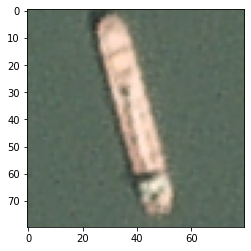

In [26]:
plt.imshow(kg_ships_patches[100])

In [70]:
kg_patch_new_size = round(kg_patch_size*SCALE_FACTOR)
print(kg_patch_new_size)
kg_patches_resize = np.zeros([kg_ships_patches.shape[0],
                            kg_patch_new_size,
                            kg_patch_new_size,
                            kg_ships_patches.shape[3]])

30


In [0]:
for img in range(kg_ships_patches.shape[0]):
  kg_patches_resize[img] = resize(kg_ships_patches[img], [kg_patch_new_size, kg_patch_new_size])

((4000, 30, 30, 3), <matplotlib.image.AxesImage at 0x7fad47395898>)

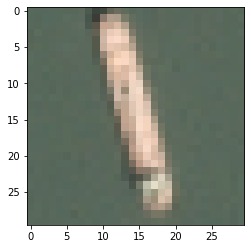

In [72]:
kg_patches_resize.shape, plt.imshow(kg_patches_resize[100])

In [0]:
# Sample data
from sklearn.model_selection import train_test_split
X_data, X_sample, y_data, y_sample = train_test_split(kg_patches_resize, 
                                                    kg_ships_df.labels, 
                                                    stratify=kg_ships_df.labels, 
                                                    test_size=0.99, 
                                                    random_state=42)

In [74]:
X_sample.shape

(3960, 30, 30, 3)

In [75]:
#Prepare Data
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop

x_train, x_test, y_train, y_test = train_test_split(kg_patches_resize, 
                                                    kg_ships_df.labels, 
                                                    stratify=kg_ships_df.labels, 
                                                    test_size=0.4, 
                                                    random_state=42)
np.unique(y_train, return_counts=True), np.unique(y_test, return_counts=True)

((array([0, 1]), array([1800,  600])), (array([0, 1]), array([1200,  400])))

In [76]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

y_train = y_train.astype('int')
y_test = y_test.astype('int')
num_classes = 2
y_train = keras.utils.to_categorical(y_train, num_classes, dtype='int')
y_test = keras.utils.to_categorical(y_test, num_classes, dtype='int')

2400 train samples
1600 test samples


In [77]:
x_train.shape

(2400, 30, 30, 3)

In [78]:
y_train

array([[1, 0],
       [0, 1],
       [1, 0],
       ...,
       [1, 0],
       [0, 1],
       [1, 0]])

In [0]:
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten, Activation

M = Sequential()
M.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(kg_patch_new_size, kg_patch_new_size, 3)))
M.add(Dropout(0.20))

M.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
M.add(MaxPooling2D(pool_size=(2, 2))) #12x12
M.add(Dropout(0.20))

M.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
M.add(MaxPooling2D(pool_size=(2, 2))) #6x6

#M.add(Conv2D(512, (3, 3), padding='same', activation='softmax'))
#M.add(MaxPooling2D(pool_size=(2, 2))) #3x3

M.add(Dropout(0.20))
M.add(Flatten())

M.add(Dense(512, activation='relu'))
M.add(Dropout(0.20))
#M.add(Dense(512, activation='softmax'))
M.add(Dense(2, activation='softmax'))

In [80]:
M.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
dropout_9 (Dropout)          (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 30, 30, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 15, 15, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 7, 7, 128)        

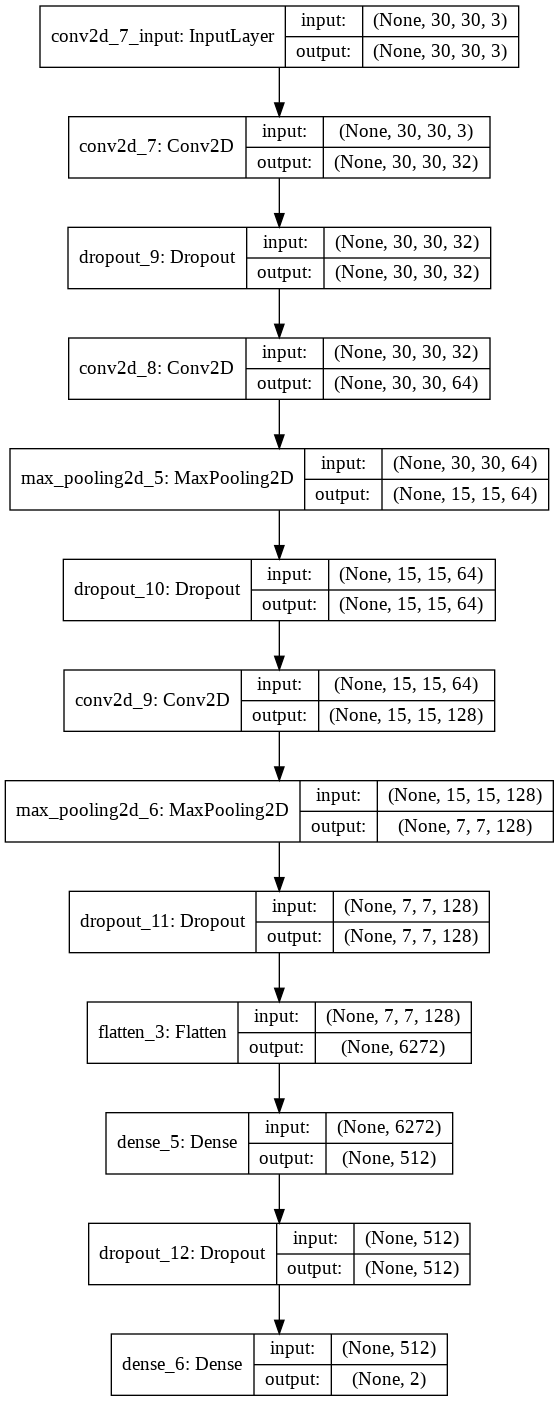

In [81]:
from keras.utils import plot_model

plot_model(M, show_shapes=True, show_layer_names=True)

In [0]:
M.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [83]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# data augmentation configuration for training data
train_datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=360)

# data augmentation configuration for test data:
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(
    x_train,
    y_train,
    batch_size=128,
    )

validation_generator = test_datagen.flow(
    x_test,
    y_test,
    batch_size=128,
    )

M.fit_generator(
    train_generator,
    steps_per_epoch=len(x_train) // 128,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=len(x_test) // 128)

Epoch 1/50
18/18 [==============================] - 2s 96ms/step - loss: 0.5878 - accuracy: 0.7434 - val_loss: 0.6075 - val_accuracy: 0.7500
Epoch 2/50
18/18 [==============================] - 1s 81ms/step - loss: 0.5656 - accuracy: 0.7544 - val_loss: 0.5636 - val_accuracy: 0.7514
Epoch 3/50
18/18 [==============================] - 1s 78ms/step - loss: 0.5637 - accuracy: 0.7509 - val_loss: 0.6337 - val_accuracy: 0.7486
Epoch 4/50
18/18 [==============================] - 1s 79ms/step - loss: 0.5683 - accuracy: 0.7469 - val_loss: 0.5783 - val_accuracy: 0.7480
Epoch 5/50
18/18 [==============================] - 1s 73ms/step - loss: 0.5604 - accuracy: 0.7509 - val_loss: 0.5738 - val_accuracy: 0.7541
Epoch 6/50
18/18 [==============================] - 1s 78ms/step - loss: 0.5619 - accuracy: 0.7500 - val_loss: 0.5508 - val_accuracy: 0.7486
Epoch 7/50
18/18 [==============================] - 1s 78ms/step - loss: 0.5519 - accuracy: 0.7425 - val_loss: 0.5183 - val_accuracy: 0.7527
Epoch 8/50
18

In [84]:
#Evaluating test loss and test accuracy
score = M.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.15718059241771698
Test accuracy: 0.9387500286102295


# Load Sentinel-2 Data

In [47]:
# Sentinel API Query
api = SentinelAPI(SENTINEL_USER, SENTINEL_PWD, 'https://scihub.copernicus.eu/dhus')

scenes = api.to_geodataframe(api.query(tileid=TILE_ID,
                                             date=('20100101','NOW'),
                                             platformname='Sentinel-2',
                                             cloudcoverpercentage=(0, 6)))
#get full scene metadata
tempList = list()
for uuid in scenes.uuid:
  tempList.append(api.get_product_odata(uuid, full=True))

sceneMeta = pd.DataFrame(tempList)
sceneMeta = sceneMeta.loc[sceneMeta['Online'] == True] # filter out images that are in Long Term Archive and have a 30 minute throttle to download

sceneMeta

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,id,title,size,md5,date,footprint,url,Online,Creation Date,Ingestion Date,Cloud cover percentage,Datatake sensing start,Date,Degraded ancillary data percentage,Degraded MSI data percentage,Filename,Footprint,Format,Format correctness,General quality,Generation time,Geometric quality,Identifier,Instrument,Instrument abbreviation,Instrument mode,Instrument name,JTS footprint,Mission datatake id,NSSDC identifier,Orbit number (start),Pass direction,Platform serial identifier,Processing baseline,Processing level,Product type,Radiometric quality,Relative orbit (start),Satellite,Satellite name,Satellite number,Sensing start,Sensing stop,Sensor quality,Size,Tile Identifier,Tile Identifier horizontal order,Level-1C PDI Identifier,Datastrip identifier,Granule identifier
0,8345c17f-dd76-4398-b4bf-2eb708631b07,S2A_MSIL1C_20191227T032131_N0208_R118_T48NUG_2...,784125118,FCD2A37B4A069C5342299AD2AEE90B41,2019-12-27 03:21:31.024,"POLYGON((103.20205689083804 1.808922187860351,...",https://scihub.copernicus.eu/dhus/odata/v1/Pro...,True,2019-12-27 08:04:08.105,2019-12-27 08:03:15.620,3.6098,2019-12-27 03:21:31.024,2019-12-27 03:21:31.024,0.0,0,S2A_MSIL1C_20191227T032131_N0208_R118_T48NUG_2...,"<gml:Polygon srsName=""http://www.opengis.net/g...",SAFE,PASSED,PASSED,2019-12-27 06:07:36,PASSED,S2A_MSIL1C_20191227T032131_N0208_R118_T48NUG_2...,MSI,MSI,INS-NOBS,Multi-Spectral Instrument,MULTIPOLYGON (((103.2027660714231 0.8160247595...,GS2A_20191227T032131_023567_N02.08,2015-028A,23567,DESCENDING,Sentinel-2A,2.08,Level-1C,S2MSI1C,PASSED,118,Sentinel-2,Sentinel-2,A,2019-12-27 03:21:31.024,2019-12-27 03:21:31.024,PASSED,747.76 MB,48NUG,NG48U,S2A_OPER_MSI_L1C_TL_EPAE_20191227T060736_A0235...,NaN,NaN
1,5d57f964-03cb-4001-a2f2-33f9eba9605e,S2B_MSIL1C_20190705T031549_N0207_R118_T48NUG_2...,779449455,5E51BCC8A45CF3ADD026433463D37D58,2019-07-05 03:15:49.024,"POLYGON((103.20205689083804 1.808922187860351,...",https://scihub.copernicus.eu/dhus/odata/v1/Pro...,True,2019-07-05 10:32:33.443,2019-07-05 09:41:20.667,5.5518,2019-07-05 03:15:49.024,2019-07-05 03:15:49.024,0.0,0,S2B_MSIL1C_20190705T031549_N0207_R118_T48NUG_2...,"<gml:Polygon srsName=""http://www.opengis.net/g...",SAFE,PASSED,PASSED,2019-07-05 06:53:23,PASSED,S2B_MSIL1C_20190705T031549_N0207_R118_T48NUG_2...,MSI,MSI,INS-NOBS,Multi-Spectral Instrument,MULTIPOLYGON (((103.2027660714231 0.8160247595...,GS2B_20190705T031549_012156_N02.07,2017-013A,12156,DESCENDING,Sentinel-2B,2.07,Level-1C,S2MSI1C,PASSED,118,Sentinel-2,Sentinel-2,B,2019-07-05 03:15:49.024,2019-07-05 03:15:49.024,PASSED,743.30 MB,48NUG,NG48U,S2B_OPER_MSI_L1C_TL_SGS__20190705T065323_A0121...,NaN,NaN


In [48]:
# download sentinel images available online
for index, row in sceneMeta.iterrows():
  uuid = row['id']
  title = row['title']
  filename = row['Filename']
  print(f'Downloading {title}')
  api.download(uuid)

Downloading: 100%|██████████| 784M/784M [00:15<00:00, 50.3MB/s]
MD5 checksumming: 100%|██████████| 784M/784M [00:01<00:00, 408MB/s]


Downloading: 100%|██████████| 779M/779M [00:16<00:00, 46.2MB/s]
MD5 checksumming: 100%|██████████| 779M/779M [00:01<00:00, 406MB/s]


In [49]:
# Unzip folders
# this creates SAFE files/directories which are explained here: https://sentinel.esa.int/web/sentinel/user-guides/sentinel-2-msi/data-formats
for index, row in sceneMeta.iterrows(): 
    title = row['title']
    filename = row['Filename']
    print(f'Unzipping {title}')
    with zipfile.ZipFile(title+'.zip', 'r') as safezip:
      safezip.extractall(filename)

Unzipping S2A_MSIL1C_20191227T032131_N0208_R118_T48NUG_20191227T060736
Unzipping S2B_MSIL1C_20190705T031549_N0207_R118_T48NUG_20190705T065323


In [50]:
image_paths = []
for index, row in sceneMeta.iterrows():
  image_paths.append(extract_rgb_jp2(row['Filename'], row['title']))
print(image_paths)

Copying T48NUG_20191227T032131_TCI.jp2 to S2A_MSIL1C_20191227T032131_N0208_R118_T48NUG_20191227T060736.jp2
Copying T48NUG_20190705T031549_TCI.jp2 to S2B_MSIL1C_20190705T031549_N0207_R118_T48NUG_20190705T065323.jp2
['S2A_MSIL1C_20191227T032131_N0208_R118_T48NUG_20191227T060736.jp2', 'S2B_MSIL1C_20190705T031549_N0207_R118_T48NUG_20190705T065323.jp2']


In [51]:
# delete unneeded files to free up space
# eventually maybe move into extraction for-loops
for name in sceneMeta.title:
  if os.path.exists(name+'.zip'):
    print(f'Deleting {name}.zip')
    os.remove(name+'.zip')
  if os.path.exists(name+'.SAFE'):
    print(f'Deleting {name}.SAFE')
    shutil.rmtree(name+'.SAFE')

Deleting S2A_MSIL1C_20191227T032131_N0208_R118_T48NUG_20191227T060736.zip
Deleting S2A_MSIL1C_20191227T032131_N0208_R118_T48NUG_20191227T060736.SAFE
Deleting S2B_MSIL1C_20190705T031549_N0207_R118_T48NUG_20190705T065323.zip
Deleting S2B_MSIL1C_20190705T031549_N0207_R118_T48NUG_20190705T065323.SAFE


In [52]:
os.listdir()

['.config',
 'shipsnet.json',
 'S2B_MSIL1C_20190705T031549_N0207_R118_T48NUG_20190705T065323.jp2',
 'scenes',
 'drive',
 '.kaggle',
 'shipsnet',
 'model.png',
 'S2A_MSIL1C_20191227T032131_N0208_R118_T48NUG_20191227T060736.jp2',
 'ships-in-satellite-imagery.zip',
 'sample_data']

In [0]:
# load ship points and scene
scene_name = sceneMeta.title[0] # 
ship_points = gpd.read_file(DRIVE_PATH+scene_name+'_SHIPS.geojson')
sat_img = rio.open(scene_name+'.jp2')

3


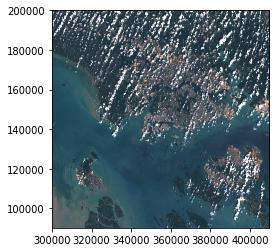

In [54]:
print(sat_img.count)
show(sat_img);

In [0]:
csv_path = DRIVE_PATH + 'sentinel_patch_classes.csv'

# sentinel_patch_classes = patch_intersects_ship_buffers(ships = ship_points, 
#                                                        img=sat_img, 
#                                                        patch_size=PATCH_SIZE, 
#                                                        step_size=STEP_SIZE)
# sentinel_patch_classes.to_csv(csv_path, index = False)

sentinel_patch_classes = pd.read_csv(csv_path)

In [56]:
sentinel_patch_classes.groupby('isShip')['isShip'].count()

isShip
False    832972
True        597
Name: isShip, dtype: int64

In [0]:
frac = 0.1

sentinel_sample = (sentinel_patch_classes
                   .groupby('isShip', # stratify by isShip
                            group_keys = False)
                   .apply(lambda x: x.sample(frac = frac, # sample by group
                                             random_state = 123))
                   .sort_index()) # the index needs to be sorted for the sample patches to "line up" with `sentinel_sample`

In [58]:
sentinel_sample.groupby('isShip')['isShip'].count()

isShip
False    83297
True        60
Name: isShip, dtype: int64

In [85]:
sentinel_sample.head()

,isShip,x,y,patch_size
17,False,204,0,30
19,False,228,0,30
24,False,288,0,30
28,False,336,0,30
51,False,612,0,30


In [0]:
pred_classes = []
for index, row in sentinel_sample.iterrows():
  pred = predict_patch(M, sat_img, row.x, row.y, row.patch_size)
  pred_classes.append(pred)

In [0]:
eval_df = sentinel_sample
eval_df['predicton'] = pred_classes
eval_df['accurate'] = eval_df.isShip == eval_df.predicton

In [97]:
eval_df.head()

,isShip,x,y,patch_size,predicton,accurate
17,False,204,0,30,[0],True
19,False,228,0,30,[0],True
24,False,288,0,30,[0],True
28,False,336,0,30,[0],True
51,False,612,0,30,[0],True


In [99]:
# accuracy
eval_df['accurate'].sum()/len(eval_df['accurate'])

0.9857240543685594

In [103]:
# pct of patches that are not ships
1-(eval_df['isShip'].sum()/len(eval_df['isShip']))

0.9992802044219442

In [106]:
# predictions
np.unique(eval_df['predicton'], return_counts=True)

(array([array([0]), array([1])], dtype=object), array([82169,  1188]))

In [104]:
# NEED TO MAKE BOTH [1,0] OR [TRUE, FALSE]
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(eval_df['isShip'], eval_df['predicton']).ravel()

ValueError: ignored

In [105]:
confusion_matrix(eval_df['isShip'], eval_df['predicton'])

ValueError: ignored